## Canny Edge Detection

### Mesyella - 2201793281

In [70]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
from PIL import Image
from scipy import ndimage

### Original Image

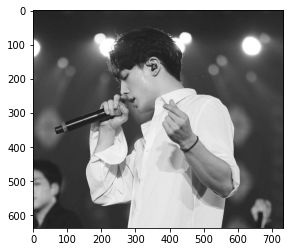

In [71]:
img = cv2.imread('2.jpg', 0)
img = img.astype('int32')
plt.imshow(img, cmap = 'gray')
plt.show()

### Noise Reduction

Edge Detection results are highly sensitive to image noise. To get rid of the noise on the image, I apply Gaussian blur filter to smooth it.

In [72]:
def gaussian_kernel(size, sigma=1):
    size = int(size) // 2
    x, y = np.mgrid[-size:size+1, -size:size+1]
    normal = 1 / (2.0 * np.pi * sigma**2)
    g =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal
    return g

### Gradient Calculation

The Gradient calculation step detects the edge intensity and direction by calculating the gradient of the image using edge detection operators. To detect it, the easiest way is to apply sobel filters that highlight this intensity change in both directions. 

#### Sobel X

In [73]:
def sobel_filters(img):
    Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
    Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
    
    Ix = ndimage.filters.convolve(img, Kx)
    Iy = ndimage.filters.convolve(img, Ky)
    
    G = np.hypot(Ix, Iy)
    G = G / G.max() * 255
    theta = np.arctan2(Iy, Ix)
    
    return (G, theta)

#### Sobel Y

#### Magnitude of the gradient

#### The slope theta of the gradient

### Non-Maximum Supression

We must perform non-maximum suppression to thin out the edges. The algorithm goes through all the points on the gradient intensity matrix and finds the pixels with the maximum value in the edge directions.

In [74]:
def non_max_suppression(img, D):
    M, N = img.shape
    Z = np.zeros((M,N), dtype=np.int32)
    angle = D * 180. / np.pi
    angle[angle < 0] += 180

    
    for i in range(1,M-1):
        for j in range(1,N-1):
            try:
                q = 255
                r = 255
                
               #angle 0
                if (0 <= angle[i,j] < 22.5) or (157.5 <= angle[i,j] <= 180):
                    q = img[i, j+1]
                    r = img[i, j-1]
                #angle 45
                elif (22.5 <= angle[i,j] < 67.5):
                    q = img[i+1, j-1]
                    r = img[i-1, j+1]
                #angle 90
                elif (67.5 <= angle[i,j] < 112.5):
                    q = img[i+1, j]
                    r = img[i-1, j]
                #angle 135
                elif (112.5 <= angle[i,j] < 157.5):
                    q = img[i-1, j-1]
                    r = img[i+1, j+1]

                if (img[i,j] >= q) and (img[i,j] >= r):
                    Z[i,j] = img[i,j]
                else:
                    Z[i,j] = 0

            except IndexError as e:
                pass
    
    return Z

### Double Threshold

In this step, we wanto to take the relevant pixels which whill contribute to the final edge. The relevant pixels are strong pixels with high intensity and weak pixels which is not enough to be considered as strong but not small enough to be considered non-relevant. The threshold I used for this assignment is 0.09 for the high threshold ration and 0.05 for the low threshold ratio.

In [75]:
def threshold(img, lowThresholdRatio=0.05, highThresholdRatio=0.09):
    
    highThreshold = img.max() * highThresholdRatio;
    lowThreshold = highThreshold * lowThresholdRatio;
    
    M, N = img.shape
    res = np.zeros((M,N), dtype=np.int32)
    
    weak = np.int32(25)
    strong = np.int32(255)
    
    strong_i, strong_j = np.where(img >= highThreshold)
    zeros_i, zeros_j = np.where(img < lowThreshold)
    
    weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))
    
    res[strong_i, strong_j] = strong
    res[weak_i, weak_j] = weak
    
    return (res, weak, strong)

### Edge Tracking by Hysteresis

Based on the threshold results, the hysteresis consists of transforming weak pixels into strong ones.

In [76]:
def hysteresis(img, weak, strong=255):
    M, N = img.shape  
    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == weak):
                try:
                    if ((img[i+1, j-1] == strong) or (img[i+1, j] == strong) or (img[i+1, j+1] == strong)
                        or (img[i, j-1] == strong) or (img[i, j+1] == strong)
                        or (img[i-1, j-1] == strong) or (img[i-1, j] == strong) or (img[i-1, j+1] == strong)):
                        img[i, j] = strong
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

### Canny Edge Detection Result

In [77]:
blur = ndimage.filters.convolve(img, gaussian_kernel(5, sigma=1.4))
mag, theta= sobel_filters(blur)
nms = non_max_suppression(mag, theta)
r, w, s = threshold(nms, lowThresholdRatio = 0.08, highThresholdRatio = 0.13)
hasil = hysteresis (r, w, s)

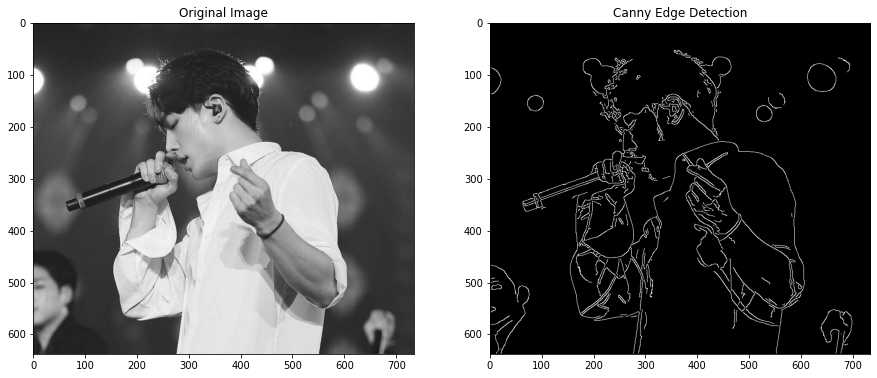

In [78]:
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)

fig.add_subplot(1,2,1)
plt.imshow(img, cmap='gray')
plt.title("Original Image")
fig.add_subplot(1,2,2)
plt.imshow(hasil, cmap='gray')
plt.title("Canny Edge Detection")
plt.show(block=True)